# CA2 Part 2 (Unsupervised Learning)

Done By: Darius Khoo  
  

Admin Number: 2222259  
  

Class: DAAA/FT/2A/06  
  

---

### **Background**
You are running a shopping mall, and you have some data about your customers like
Age, Gender, Income and Spending.

### **Task** 
- Perform customer segmentation using Unsupervised Learning algorithms.

- Describe the characteristics of each customer cluster.

- Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them.

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

rng = np.random.RandomState(42)

from warnings import filterwarnings 
filterwarnings('ignore')

# Hopkins Statistic
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform

df = pd.read_csv('./data/Customer_Dataset.csv')


In [259]:
# Functions

## *Exploratory Data Analysis*



---

In [260]:
df.head(8)

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [262]:
df.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


As we can see its pretty basic information with all the columns having no null values however there are some key takeaways i can gain from this data.

1. The age of the customers range from 18 to 70 with the average age being 38.85 years old.

2. the lowest income being 15,000.00 and the highest being 137,000.00

3. customers spend as little as 1 and as much as 99 however i have no idea what the unit of measurement is.



Although this information doesn't really help with clustering, it helps me understand the context of each cluster later on my final clustering model.


---

## Univariate Analysis

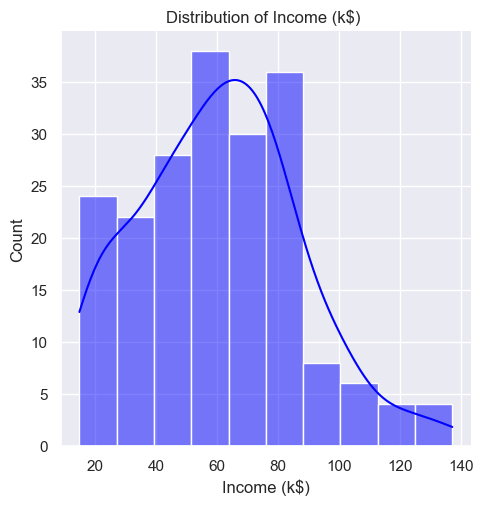

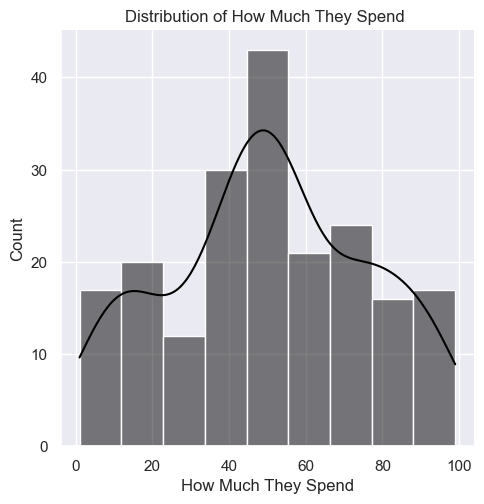

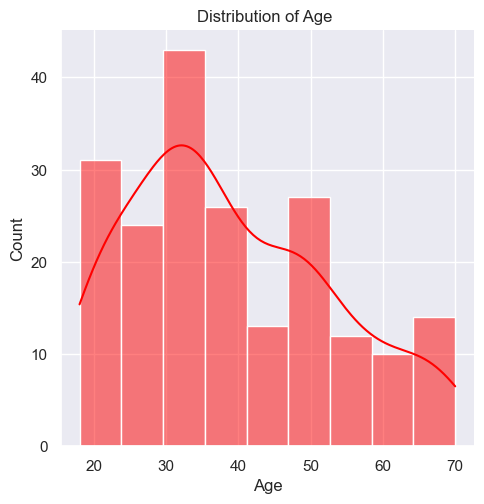

In [266]:

x_values = ['Income (k$)', 'How Much They Spend', 'Age']
colors = ['blue', 'black', 'red']

for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

>We can see the distribution of income is skewed to the right, with age having a very slight skew as well, compared to those the spending is the most normally distributed one, this observation prompt me to consider standardization/normalization later on in the clustering process.

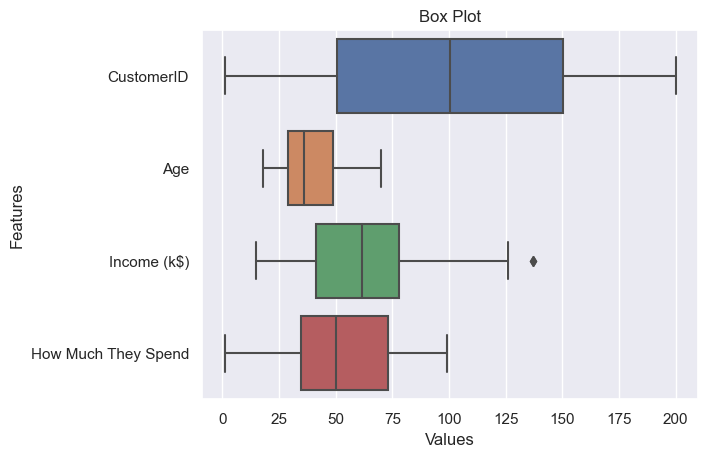

In [267]:
sns.boxplot(data=df , orient= 'h')

plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

plt.show()

>the box plot shows that the plots are actually quite regular, with only income have 1 outlier likely due to the fact that the income is skewed to the right. however the rest seem to be quite normal. 

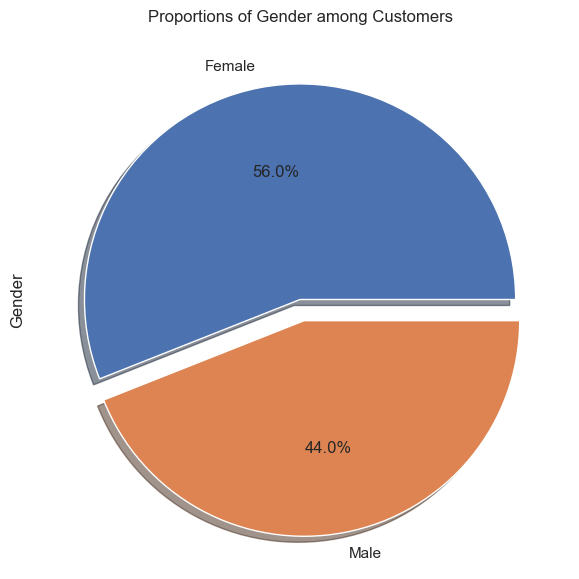

In [268]:
# pie chart on resign status
fig, ax = plt.subplots(figsize=(10, 7))
fig.set_facecolor("white")
df["Gender"].value_counts().plot.pie(
    title="Proportions of Gender among Customers",
    legend=False,
    autopct="%1.1f%%",
    explode=(0, 0.1),
    shadow=True,
    startangle=0,
)
plt.show()

>surprising the shoppers in the mall are quite equal among gender with almost a 50 50 split this tells me there is no imbalance in the data in terms of gender.

these table can't tell me direct information unless i test for them further however they do give me a good idea of what to expect in the data and what are my future steps

---

## Visualizing the dataset as a whole

In [269]:
df = pd.read_csv('./data/Customer_Dataset.csv')
# df = df.drop('CustomerID', axis=1)
df

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


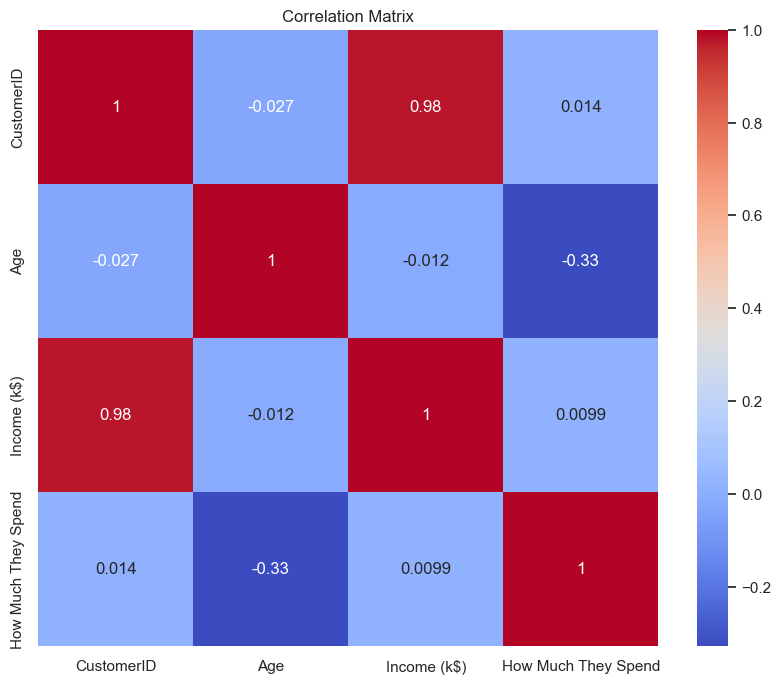

In [270]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

correlation plot shows no feature that are highly correlated which is good, however income and customerid are strangly extremely correlation, However it doesn't say much it is likely due to the fact that they order the customers by their income hence as customer id increase, so does income. Customer Id actually doesn't help in the process of clustering so i will drop it later on.

## Gender column

Based on the pie chart above i seen that the genders are quite equal, leading me to question whether it is actually needed to label the gender in each data point.

Logically speaking, gender would definitely play an important role in the spending habits, certain gender might have a more specific spending habit which can allow for easy clustering to happen.

Is that the case for this dataset though? lets do a few test to see if its True or False.


The steps are namely:
-  A box plot to visualize if there are any obvious difference in each feature by gender

- Further step can only be done after i preprocess the data, so that will be included in the later part

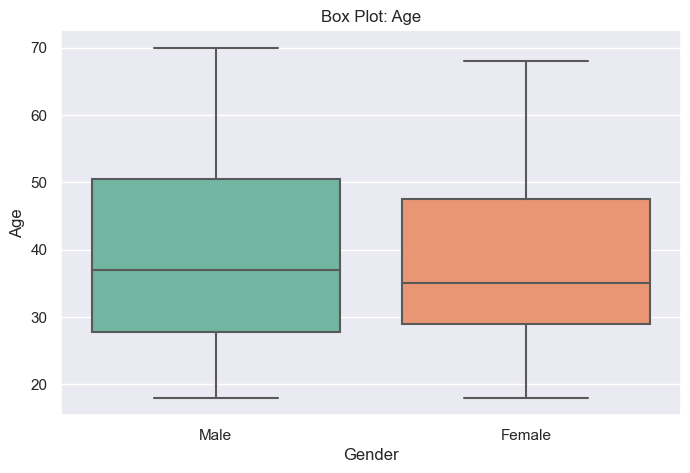

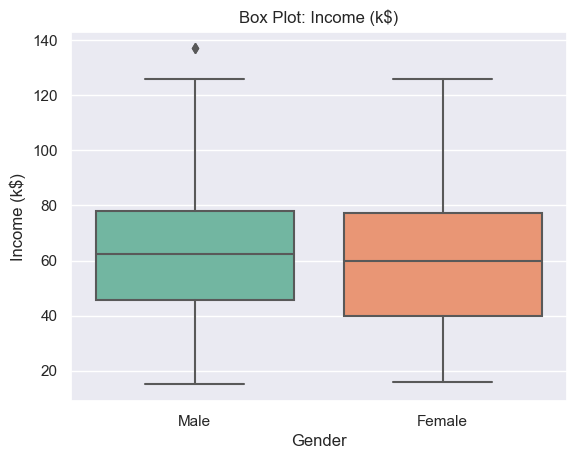

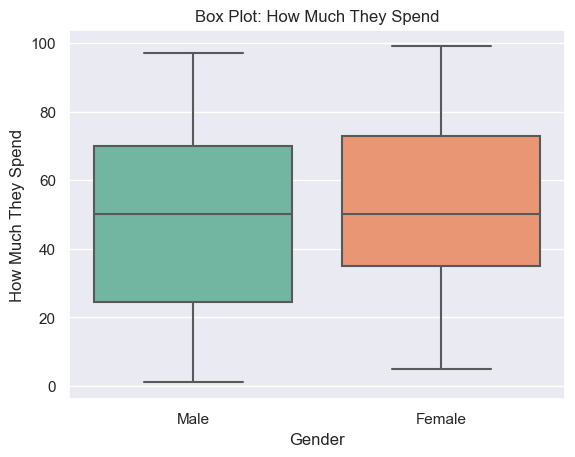

In [271]:
plt.figure(figsize=(8, 5))

for feature in df.columns:
    if feature != 'Gender' and feature != 'CustomerID':  # Exclude the Gender and Customer ID column
        sns.boxplot(x='Gender', y=feature, data=df, palette='Set2')
        plt.title(f"Box Plot: {feature}")
        plt.xlabel("Gender")
        plt.ylabel(feature)
        plt.show()

>As we can see directly from these box plots there isn't really a noticable difference in the 2 genders, however we can't just decide to drop gender as a feature yet, we need to do further testing to see if it is really not needed.

---

## Data Preprocessing

Just like most machine learning project data preprocessing is an important step consisting of

- Data Encoding
- Data Scaling
- Dimension Reduction

just to name a few of the possible steps, now lets apply preprocessing for our data

---

Our dataset is actually quite small with only a few features which is a good thing, however we still have 1 categorical value that we need to encode that being Gender, however we need to take note of the scaler we use as scalers like OneHotEncoder will add new columns effectively creating more dimensions for our model in the future

There are a few encoders we could use

- LabelEncoder
- OneHotEncoder
- OrdinalEncoder

Since our only categorical column being Gender with the values consisting of either Male or Female, OneHotencoder's problem of creating extra dimension will not affect our data since its either 1 or 0 for each gender so we will use OneHotEncoder

In [272]:
df = pd.read_csv('./data/Customer_Dataset.csv')

# drop the customer ID first since it is not needed

df = df.drop('CustomerID', axis=1)
df

,Gender,Age,Income (k$),How Much They Spend
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [273]:
encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(df[['Gender']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Gender']))
data_encoded = df.drop(['Gender'], axis=1)

# add the encoded data to the original data
data_encoded = pd.concat([data_encoded, encoded_df], axis=1)
data_encoded = data_encoded.drop(['Gender_Male'], axis=1)

data_encoded

,Age,Income (k$),How Much They Spend,Gender_Female
0,19,15,39,0.0
1,21,15,81,0.0
2,20,16,6,1.0
3,23,16,77,1.0
4,31,17,40,1.0
...,...,...,...,...
195,35,120,79,1.0
196,45,126,28,1.0
197,32,126,74,0.0
198,32,137,18,0.0


After encoding since i kept the gender female column  
the `0` will =  `Male`  
the `1` will = `Female`

## *Standardization and Normalization*


as the data shown,we have both outliers and skewed data, since common models such as Kmeans and DBSCAN are sensitive to outliers and skewed data, we need to apply some form of scaling to the data, however which one should we use? 

i will choose <u> `Standardization` </u> 

With our data, the range of values are not very important and i do not need to keep them, hence i will use standardization to scale the data



In [619]:
columns_to_scale = ['Income (k$)', 'How Much They Spend', 'Age']
# of course we don't scale the gender column

# Create a subset of the DataFrame with the selected columns
data_subset = data_encoded[columns_to_scale]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
scaled_data = scaler.fit_transform(data_subset)

# Replace the original values with the scaled values
data_encoded[columns_to_scale] = scaled_data

In [278]:
data_encoded

,Age,Income (k$),How Much They Spend,Gender_Female
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,1.0
196,0.441365,2.497807,-0.861839,1.0
197,-0.491602,2.497807,0.923953,0.0
198,-0.491602,2.917671,-1.250054,0.0


>Once all these preprocessing steps are done, we can finally proceed with feature engineering deciding if i want to drop the column or not

---

## Feature Engineering 

as we have seen above the difference in gender might not be very different 

we can see similar variance hence we can proceed with the test
i will be checking using a test

- 2 sample t-test

In [279]:
data_encoded.groupby('Gender_Female').var()

,Age,Income (k$),How Much They Spend
Gender_Female,,,
0.0,1.239763,1.033824,1.172881
1.0,0.823420,0.985774,0.876433


since the variance between the 2 genders are equal we can do 2 sample t test with equal variance

In [280]:
def two_sample_t_test(data, col, level = 'Gender_Female', equal_variances = True, significance_level = 0.05):
    pivoted_data = data.pivot(columns=level)[col]
    a, b = pivoted_data.iloc[:, 0].dropna(), pivoted_data.iloc[:, 1].dropna()
    text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are equal\nH1 : Population means are not equal\nSignificance Level = {significance_level}"
    #text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are not equal\nH1 : Population means are equal\nSignificance Level = {significance_level}"
    print(text)
    t_score, pvalue = stats.ttest_ind(a, b, equal_var=equal_variances)
    print("The p-value is", pvalue)
    if pvalue > significance_level:
        print("There is insufficient evidence to reject the null hypothesis that the population means are equal.")
    else:
        print("There is evidence to reject the null hypothesis that the population means are equal.")

In [281]:
for col in ('Age', 'Income (k$)', 'How Much They Spend'):
    print(col)
    two_sample_t_test(data_encoded, col)
    print()

Age
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.39189073778825656
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Income (k$)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.42755249399927864
There is insufficient evidence to reject the null hypothesis that the population means are equal.

How Much They Spend
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.41374465898521817
There is insufficient evidence to reject the null hypothesis that the population means are equal.



>Since t-test shows that the means are equal across all the features, i can finally conclude that in this dataset the gender has no affect on the spending habit, and we can drop gender column

In [282]:
final_df = data_encoded.drop('Gender_Female', axis=1)


In [283]:
final_df

,Age,Income (k$),How Much They Spend
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [306]:
df = df.drop('Gender', axis=1)


---

## *Data Preparation*

i will mainly be testing for 2 things 

- Cluster Tendency Test: Hopkins Test

- Density Estimation



In [603]:
# based on the hopkins statistic concept and equation 
# (Meerkat Statistics, 2023)

def hopkins_test(X):
    X = X.values
    sample_size = int(X.shape[0] * 0.1)
    
    ujd = []
    wjd = []

    min_values = X.min(axis=0)
    max_values = X.max(axis=0)
    uniform_sample = np.random.uniform(min_values, max_values, (sample_size, X.shape[1]))
    # print(uniform_sample)
    random_indices = sample(range(0, len(x), 1), sample_size)
    X_sample = X[random_indices]
    
    neighbors = NearestNeighbors(n_neighbors=2).fit(X)
    
    u_distances, something = neighbors.kneighbors(uniform_sample, n_neighbors=2)
    ujd = u_distances[: , 0]

    # returns the distance and the indices (but i don't need the indices)
    w_distances, something = neighbors.kneighbors(X_sample, n_neighbors=2)

    wjd = w_distances[: , 1]

    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    return H


In [636]:
s = hopkins_test(final_df)
print(f"Our hopkins statistic is {s:.4f}")

Our hopkins statistic is 0.6456


> With the hopkins test coming back at around 0.60 ish we can tell that the data naturally has some degree of clusterable structure, however it is not extremely pronounced, which is still okay since its a moderate score already.

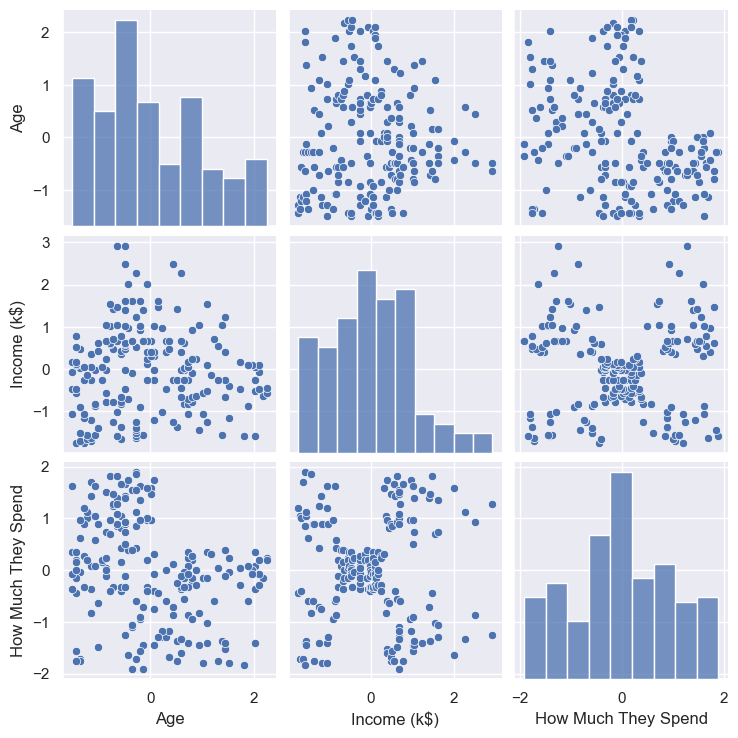

In [457]:
sns.pairplot(final_df)
plt.show()

> as we can infer visually from the pairplot, there are some features such as (spending and income) that has some clear clusters, however there are the rest of the features just look randomly distributed with no defining clusters at all, this is a good sign as it means that the data is not too clustered and we can proceed with clustering.

# *Clustering* 

we will be using a few models to try and cluster our data which includes

- KMeans (distance based clustering)
- DBSCAN (density based clustering)
- Agglomerative Hierarchical Clustering (hierarchical clustering)


## KMeans
with KMeans we need to specify the number of clusters we want to have, however we don't know what that value is so i will loop through multiple value and evaluate the results on multiple factors being:  
>`Silhouette Analysis`, `Elbow Plot(Inertia)`

In [291]:
def clusters_inertia(data, max_clusters):
    inertias = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        inertias.append(inertia)

    return inertias

def clusters_silhouette(data, max_clusters):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_score_val = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_score_val)

    return silhouette_scores


In [292]:
max_clusters = 20
x_values = list(range(2, max_clusters + 1))
inertias = clusters_inertia(final_df, max_clusters)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=inertias, mode='lines'))

fig.update_layout(
    title='Elbow Plot',
    xaxis_title='Number of Clusters',
    yaxis_title='Inertia'
)

fig.show()

>With inertia the lower the better so the possible good number of clusters can be around <u>6 onwards</u>, Choosing the number of clusters just based on inertia may not be the most accurate so lets consider the silhouette score as well.


In [293]:
max_clusters = 20
x_values = list(range(2, max_clusters + 1))
silhouette_scores = clusters_silhouette(final_df, max_clusters)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=silhouette_scores, mode='lines'))

fig.update_layout(
    title='Elbow Plot',
    xaxis_title='Number of Clusters',
    yaxis_title='Silhouette Score'
)

fig.show()

>For the case of silhouette score its the opposite of inertia, where the higher the score the better as we can see from the plot, the peak silhouette score happens at around 6 clusters which agrees with the inertia analysis as well, Hence for a baseline we can use 6 clusters for our model, however i wish to test number of clusters after 6 since based on the plot the result aren't the worst either, especially inertia plot where the score gets better at higher clusters

---

### Analysis of the clusters
i get the mean of each cluster allow me to do analysis

In [294]:
# IMPORTANT DON'T DELETE

#  Get the Analysis of each cluster (Mean of each feature in that cluster)
def cluster_analysis(data, labels):
    cluster_analysis = pd.DataFrame(columns=data.columns)
    
    for cluster in np.unique(labels):
        cluster_data = data[labels == cluster]
        cluster_average = cluster_data.mean()
        
        cluster_analysis.loc[cluster] = cluster_average
    
    cluster_analysis['Cluster'] = np.unique(labels)
    
    return cluster_analysis

---

For n_clusters = 5 The average silhouette_score is : 0.4113312881915614


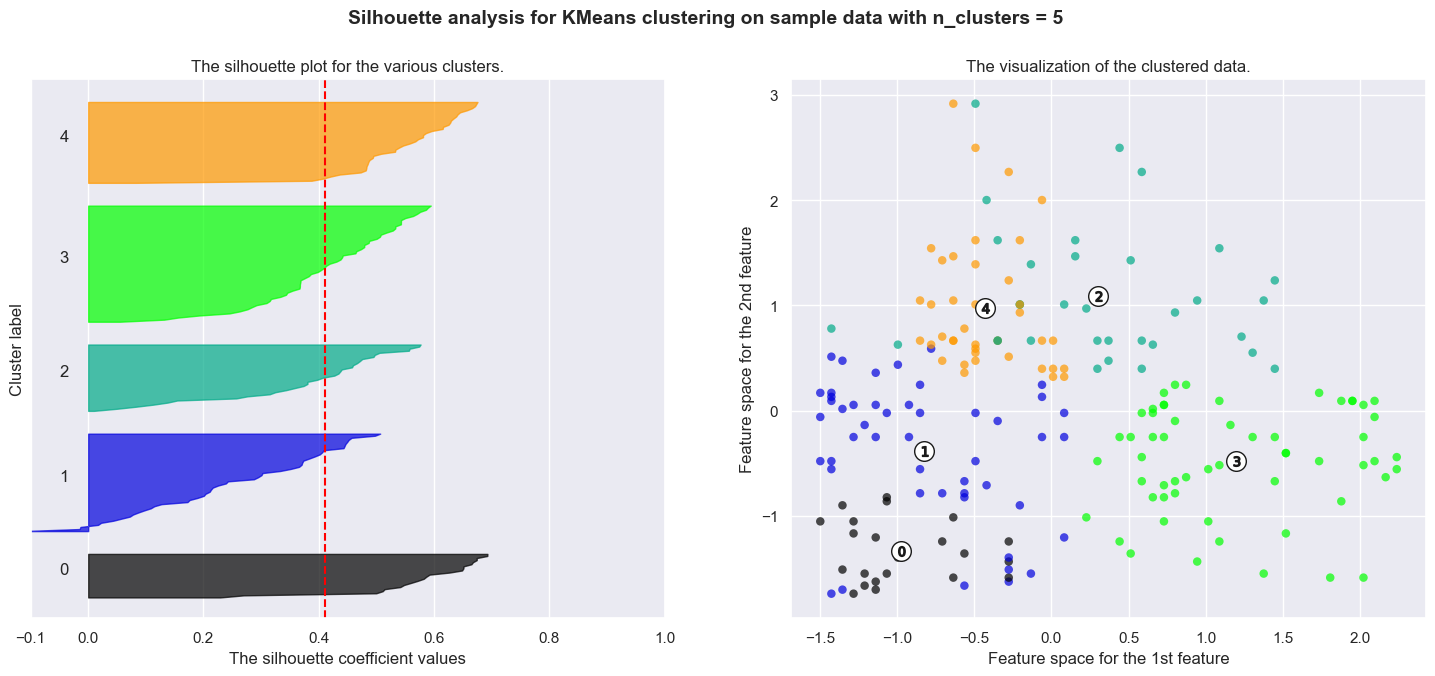

For n_clusters = 6 The average silhouette_score is : 0.429210925806494


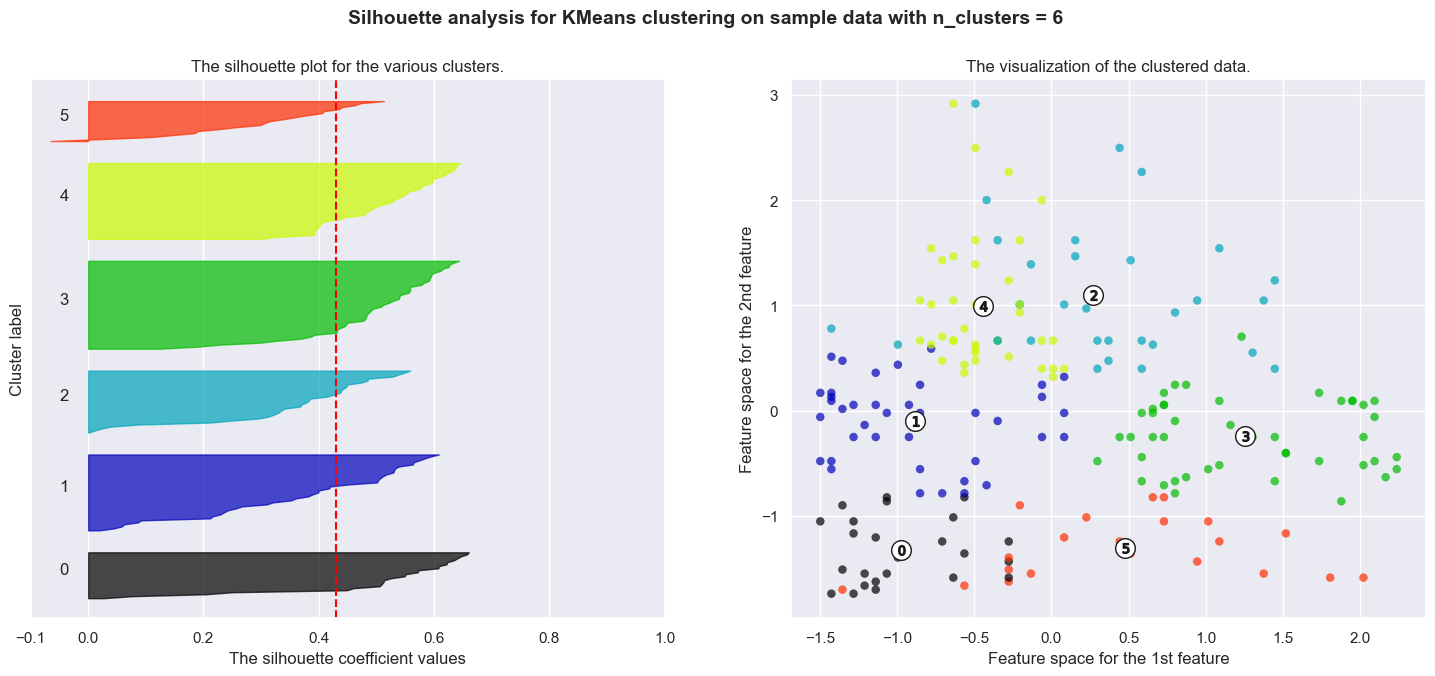

For n_clusters = 7 The average silhouette_score is : 0.40685173071203623


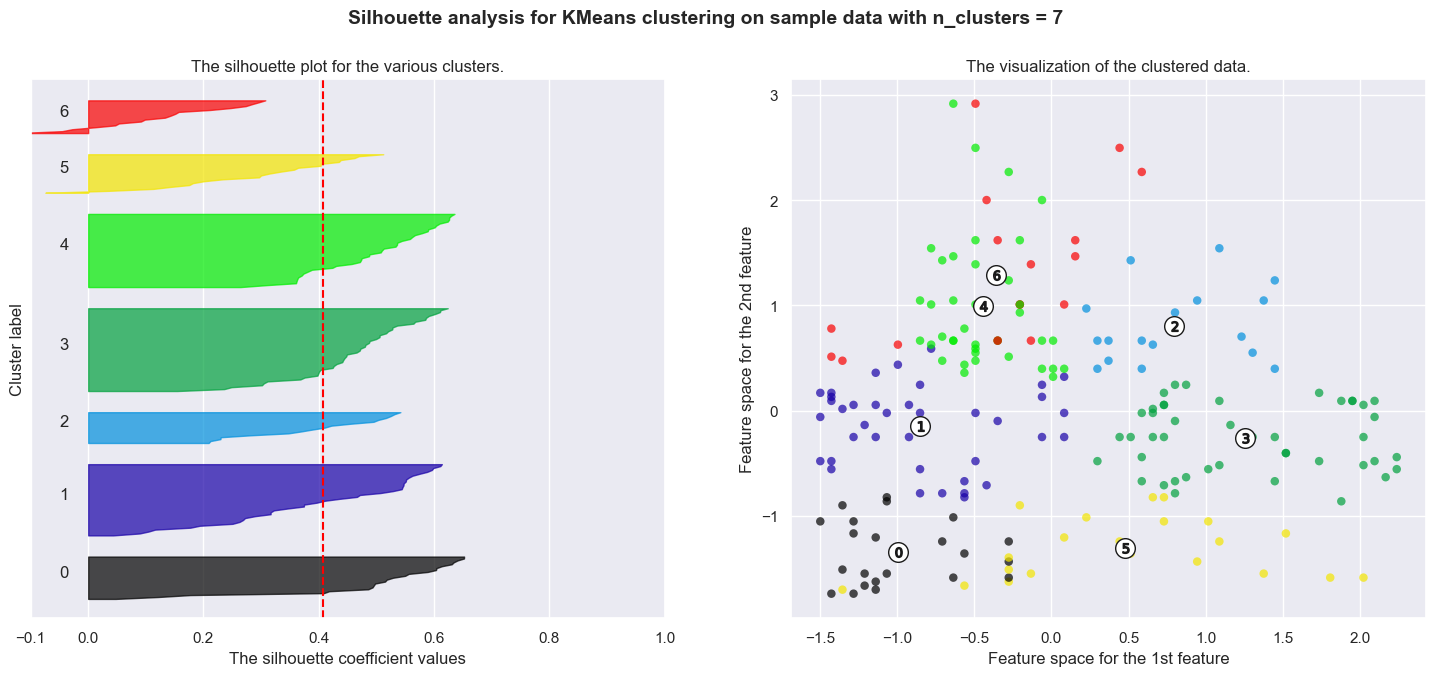

For n_clusters = 8 The average silhouette_score is : 0.4277474941616527


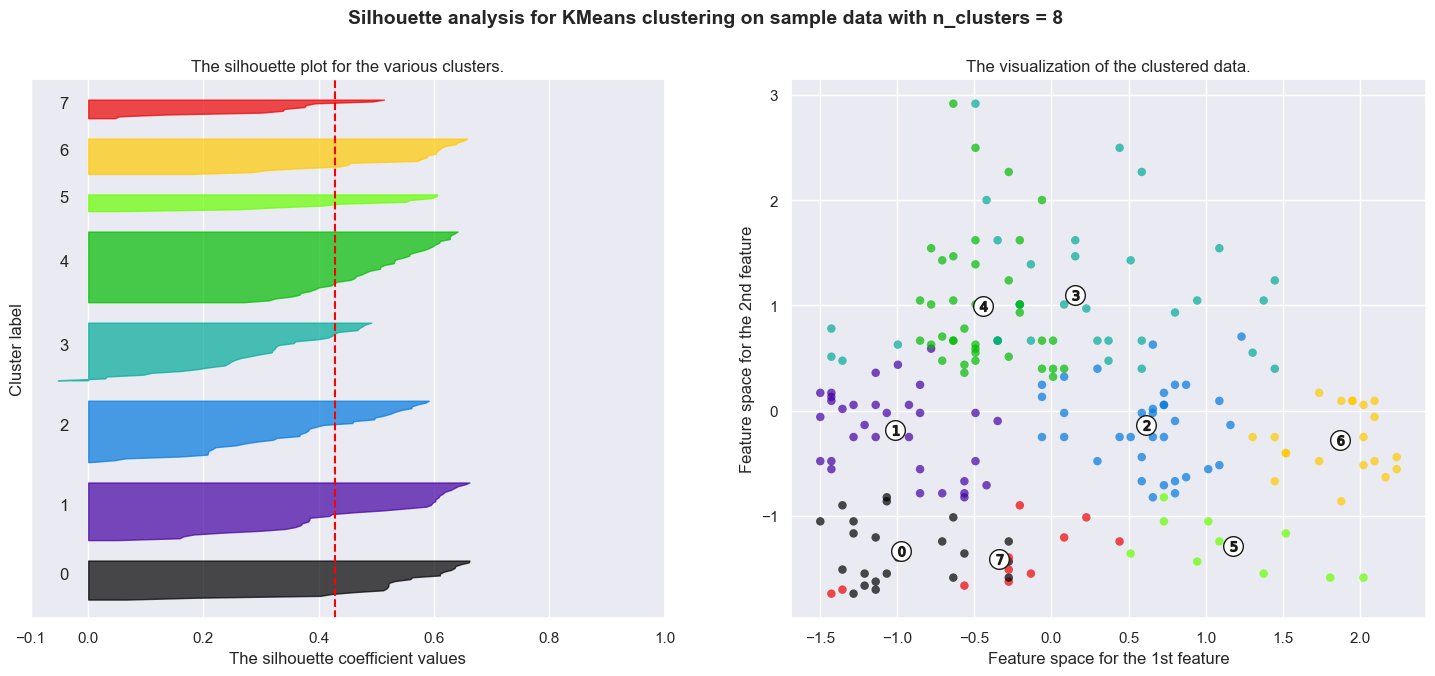

For n_clusters = 9 The average silhouette_score is : 0.4188078334648395


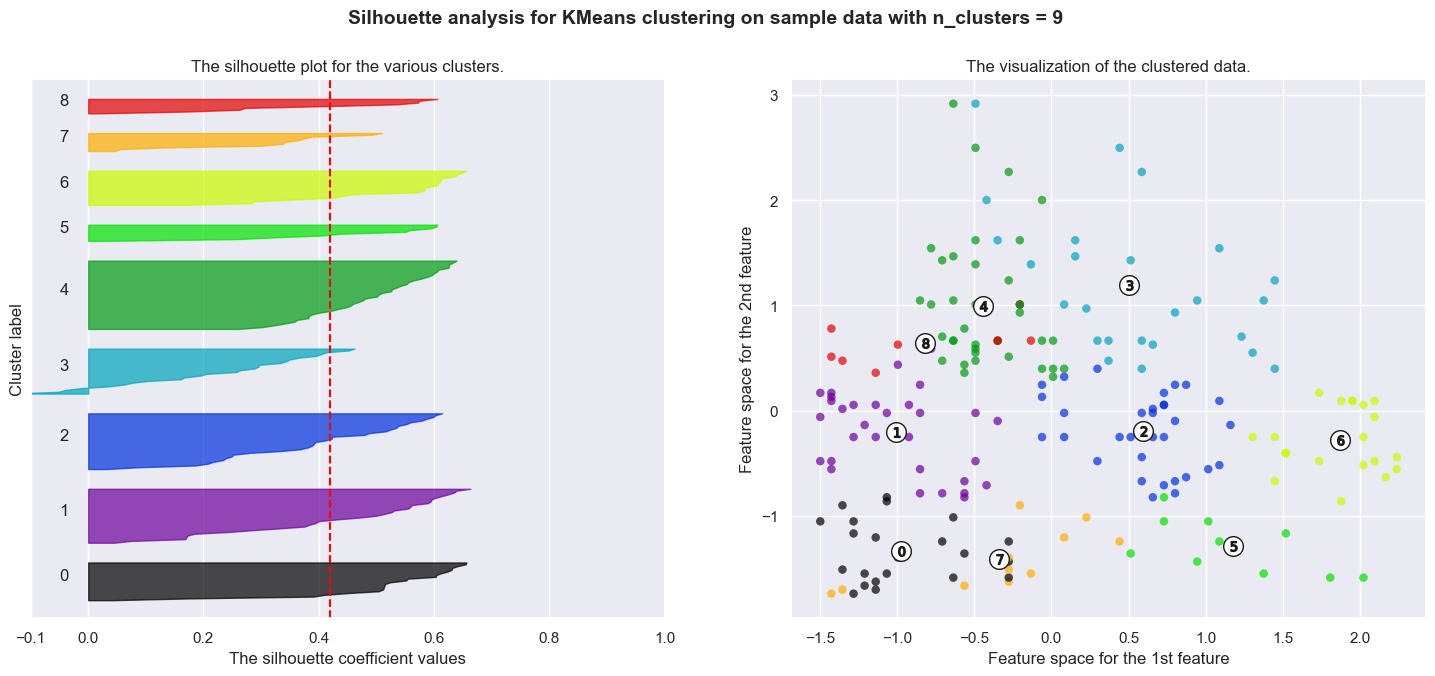

For n_clusters = 10 The average silhouette_score is : 0.4003965743727067


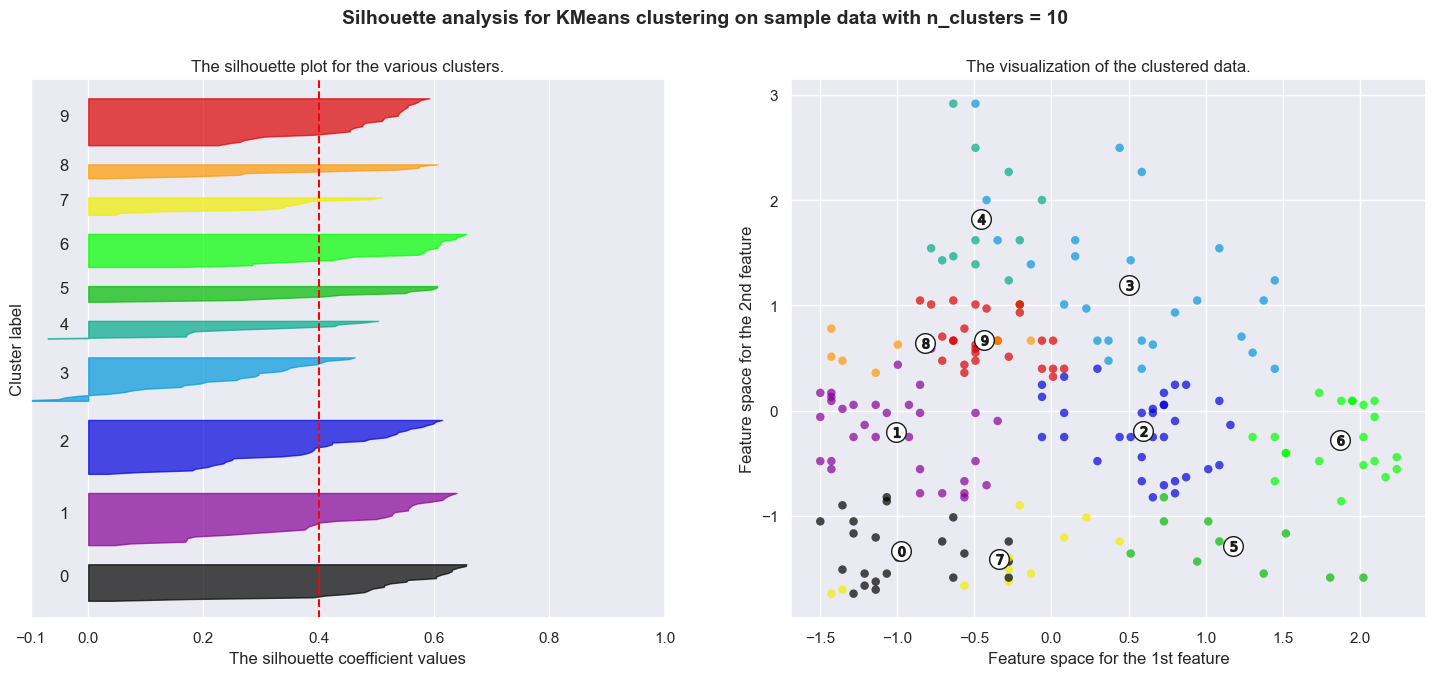

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

# referenced from
## (Selecting the Number of Clusters With Silhouette Analysis on KMeans Clustering, n.d.)


def perform_silhouette_analysis(df, range_n_clusters):
    X = df.values  
    
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=150, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        centers = clusterer.cluster_centers_
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        plt.show()






cluster_range = range(5, 11)
perform_silhouette_analysis(final_df, cluster_range)

> as we can see from the graph, the clusters aren't badly defined at the start however as the number of clusters grew it got worse and worse with the clusters getting more and more mixed up, with Kmeans using distance based clustering just randomly clustering data to get the number of clusters desired it is no suprise the high clusters get worse since our data is not naturally clustered

Hence i decided that <u> 6 clusters </u> provide us with the best results having the the highest average silhouette score as well compared to other number of clusters

---

Silhouette Plot:

The silhouette plot displays the silhouette coefficients for each data point within the clusters. Each data point is represented by a vertical bar in the plot.
The x-axis represents the silhouette coefficient values, which range from -1 to 1. The closer the coefficient is to 1, the better the data point is clustered.
The y-axis shows the cluster labels. The data points are grouped vertically by their assigned clusters.
Each cluster's silhouette plot is filled with colored bars representing the silhouette coefficients of its data points. These bars are sorted in ascending order.
The position of the bar within the cluster indicates how well the data point is separated from neighboring clusters. Data points with higher coefficients are well-separated within their cluster.
The width of the bars indicates the relative size of the clusters. Wider bars suggest larger clusters.




---

Since the silhouette analysis, was not really what i expected i decided why not check the analysis of lower number of clusters as well seeing if it is better or worse

For n_clusters = 2 The average silhouette_score is : 0.33547192894004574


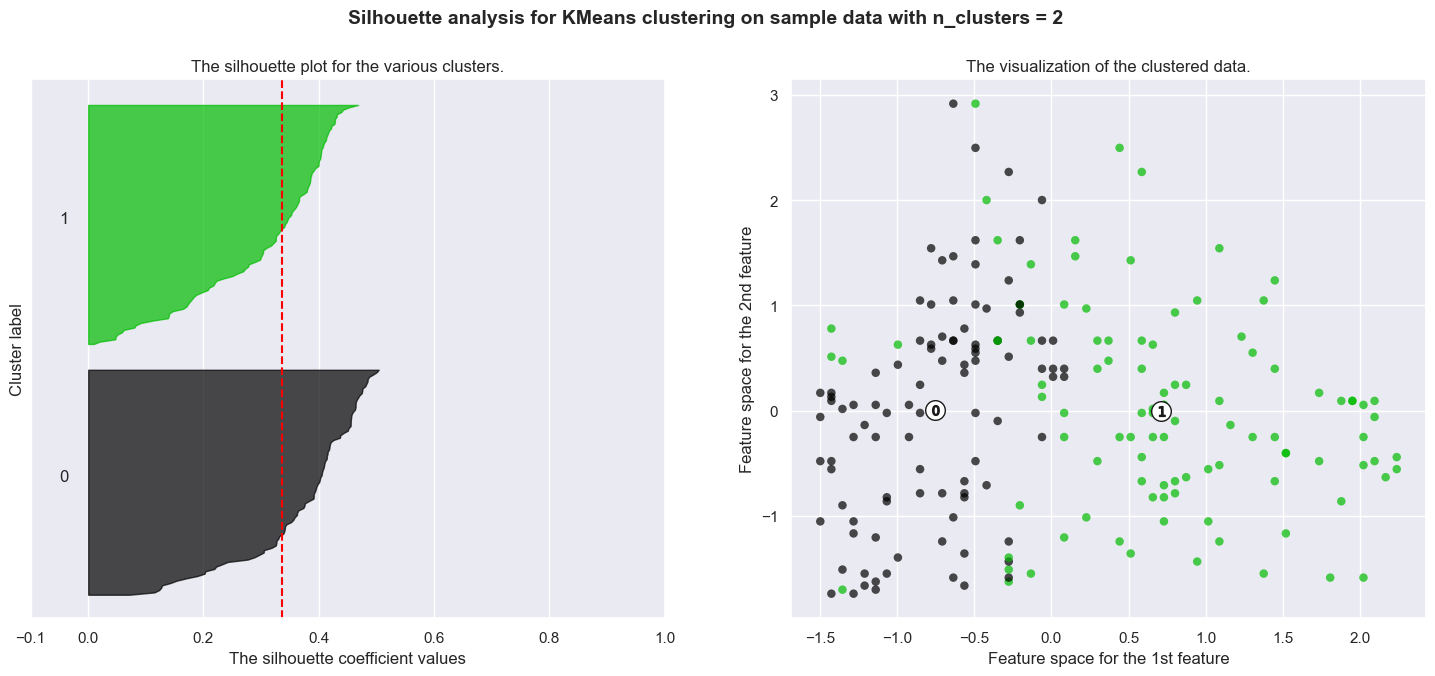

For n_clusters = 3 The average silhouette_score is : 0.3159981430254522


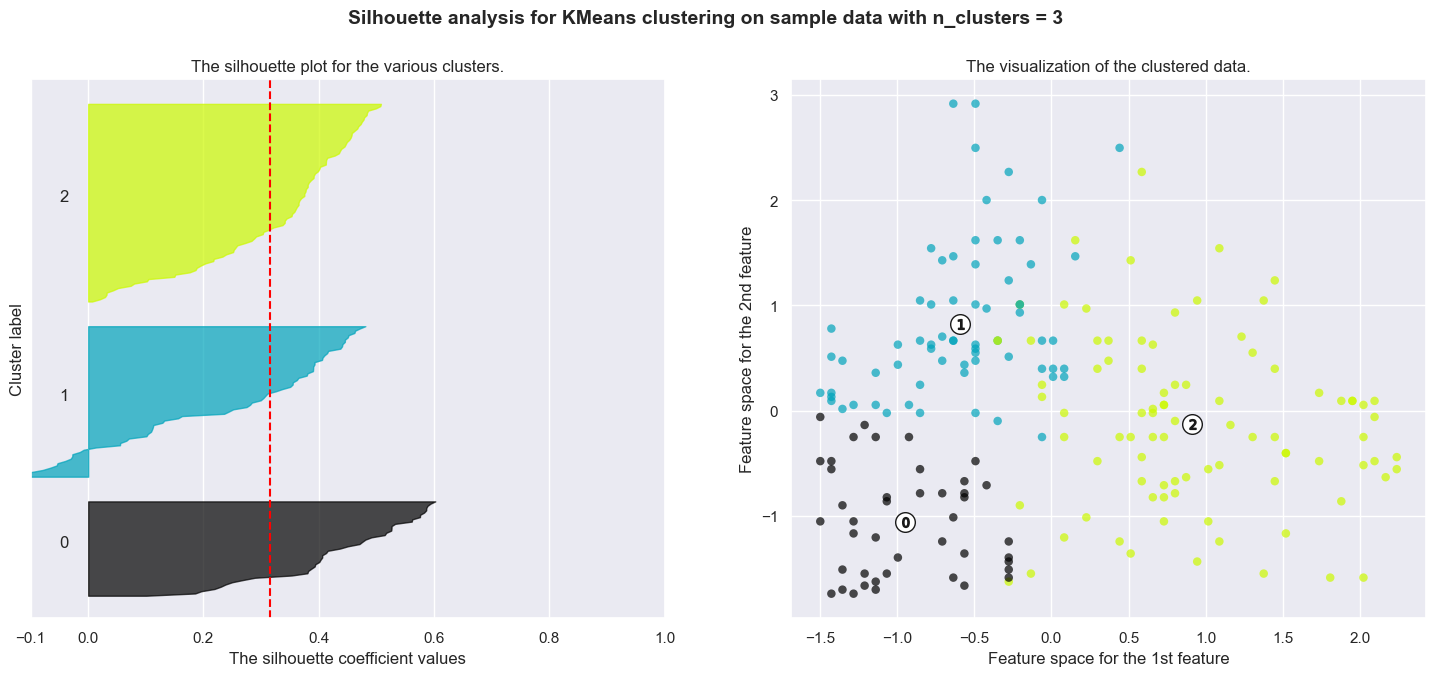

For n_clusters = 4 The average silhouette_score is : 0.4039582785148566


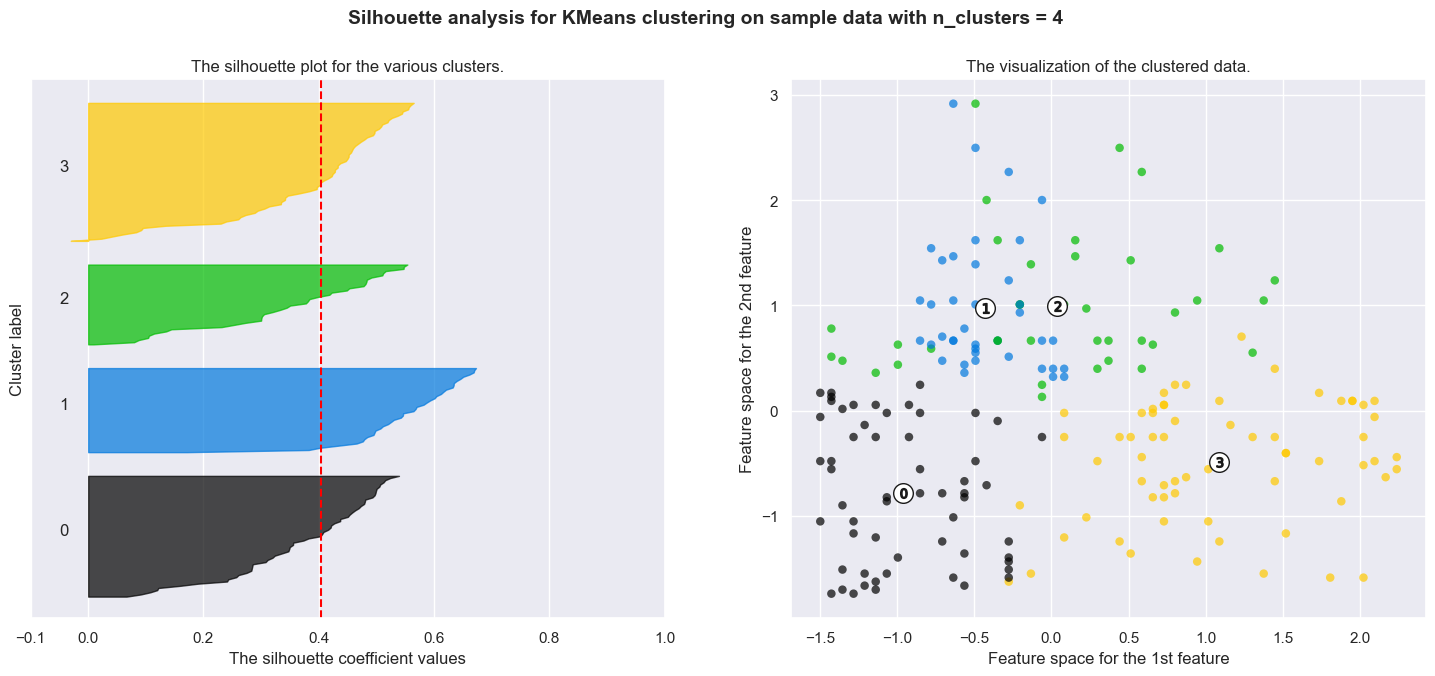

For n_clusters = 5 The average silhouette_score is : 0.4113312881915614


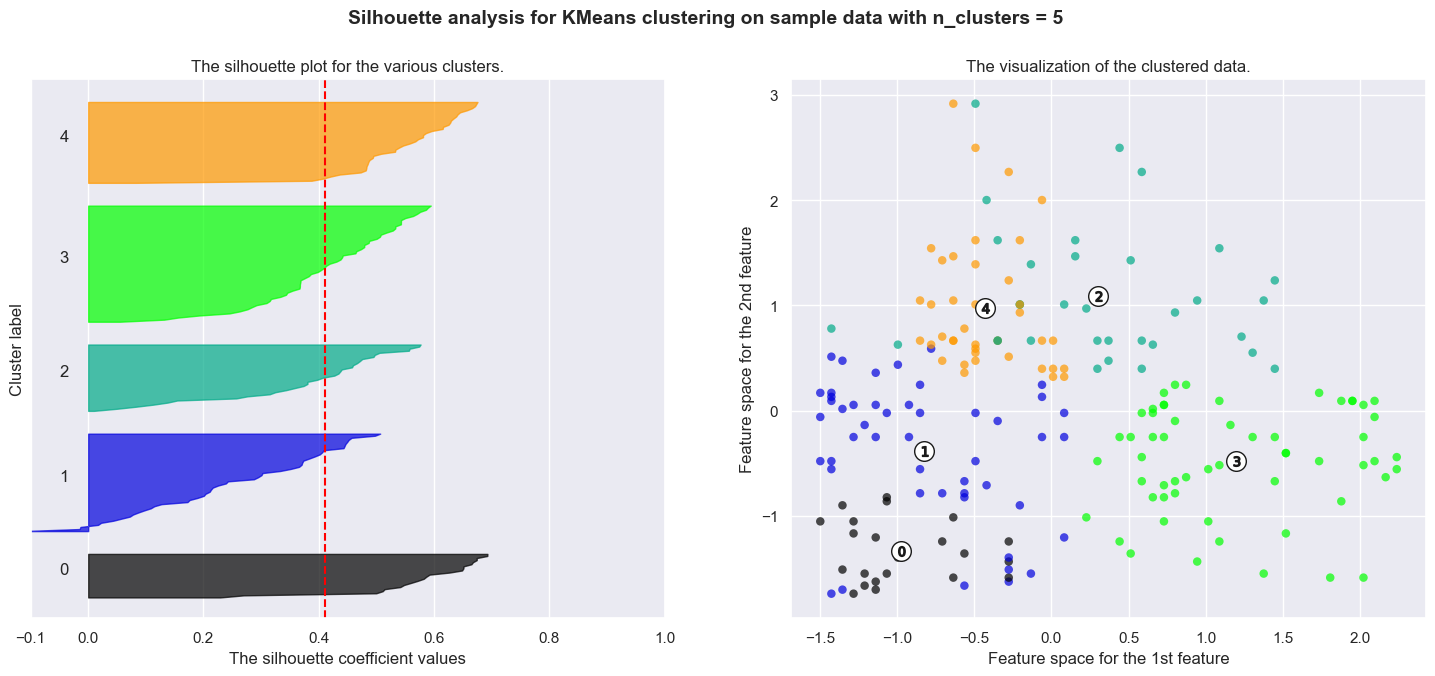

For n_clusters = 6 The average silhouette_score is : 0.429210925806494


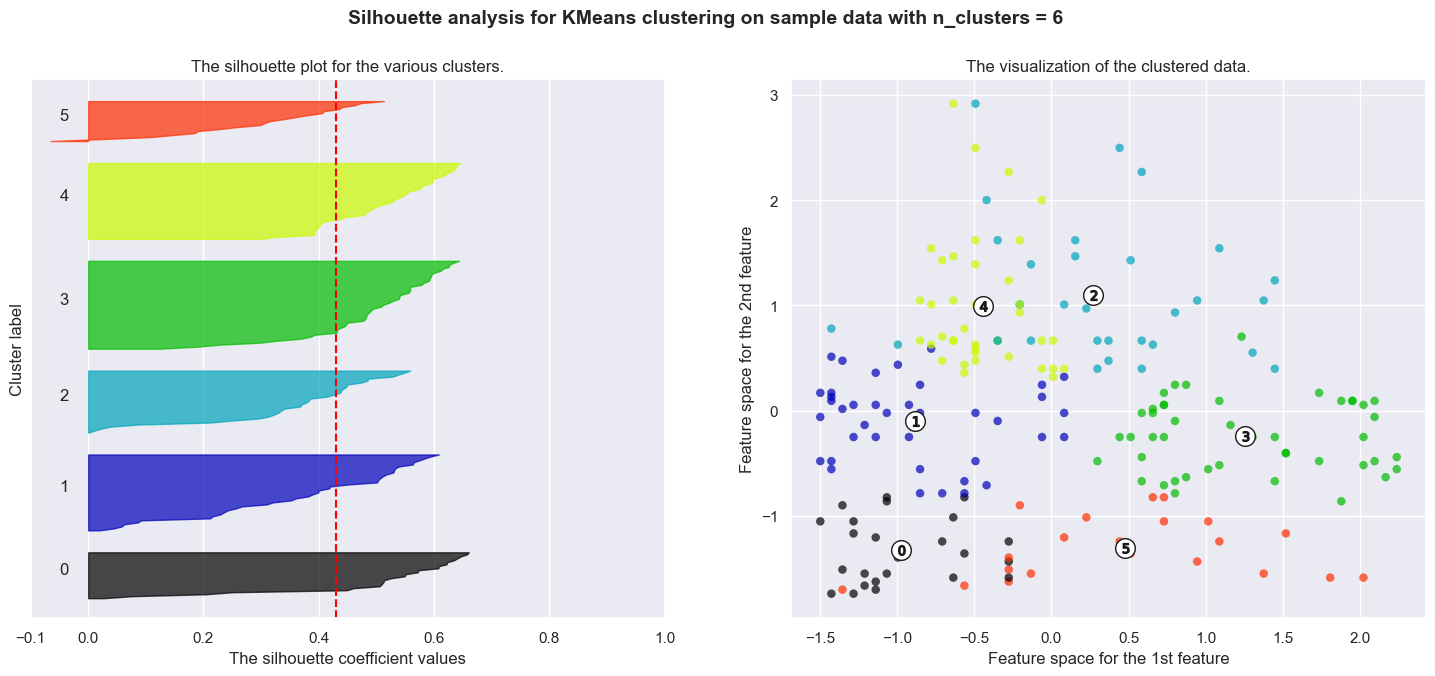

In [621]:
cluster_range = range(2, 7)
perform_silhouette_analysis(final_df, cluster_range)

Size of each pole don't matter that much, its more important to compare how many poles are closer to 1, the closer the better

>Once again  we can see the average silhouette score is highest at 6 clusters with other lower number of cluster performing worse with only cluster 5 coming close, however to provide me with more insights on each cluster better i choose the option with slightly more clusters  
><u> hence for Kmeans 6 clusters seem the most optimal option </u>

In [307]:
kmeans = KMeans(n_clusters=6, random_state=10)
data_points = final_df.values
labels = kmeans.fit_predict(data_points)

analysis_result = cluster_analysis(df, labels)

analysis_result

,Age,Income (k$),How Much They Spend,Cluster
0,32.692308,86.538462,82.128205,0
1,45.523810,26.285714,19.380952,1
2,25.250000,25.833333,76.916667,2
3,41.939394,88.939394,16.969697,3
4,26.684211,57.578947,47.789474,4
5,56.333333,54.266667,49.066667,5


here i can see the mean of each cluster and do analysis on them however that isn't really important right now i just want to see how distinct each cluster is determining if its is well defined and useful for our case

and i can conclude it isn't anything amazing with some of the clusters looking quite similar such as cluster 5 and 6 having quite similar means for 2 of its feature, however if other models perform worse i will still use this model, since the clusters produced aren't bad at all

---

## DBSCAN 

(<u> Density-Based </u> Spatial Clustering of Applications with Noise)

DBSCAN has 2 parameters notably `eps` and `min_samples`

i will once again need to choose the best values for this parameters so that the model can perform to its best similarly i will perform the same 2 analysis methods as before:

- Silhouette Analysis for both eps and min_samples

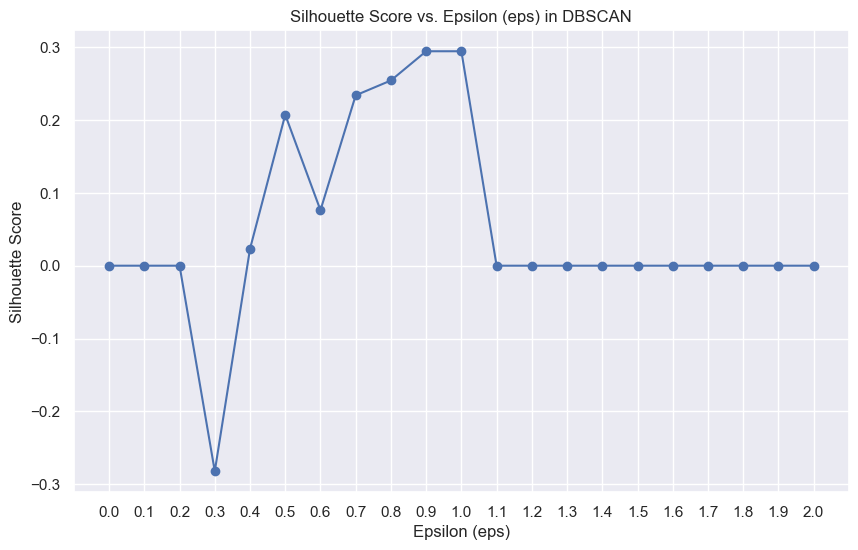

In [377]:
eps_start = 0
eps_end = 2
eps_step = 0.1
eps_values = np.arange(eps_start, eps_end + eps_step, eps_step)

silhouette_values = np.zeros(len(eps_values))

for idx, eps in enumerate(eps_values):
    try:
        # for min_samples the rule of thumb is: 2*len(features) 
        # so since i got 3 features i set it to 2*3 = 6 first
        preds = DBSCAN(eps=eps, min_samples=6).fit_predict(final_df)
        if len(np.unique(preds)) > 1:  # Skip if only one cluster and noise
            silhouette_values[idx] = silhouette_score(final_df, preds)
    except:
        pass

plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Epsilon (eps) in DBSCAN')
plt.xticks(eps_values)  # Set x-axis tick locations
plt.grid(True)
plt.show()

>the peak of eps is around 0.9 to 1.0 with some other values performing not bad too so for now i will take note of eps = 0.9, 1.0 and decide once and for all later on 

---

## Eps = 1.0

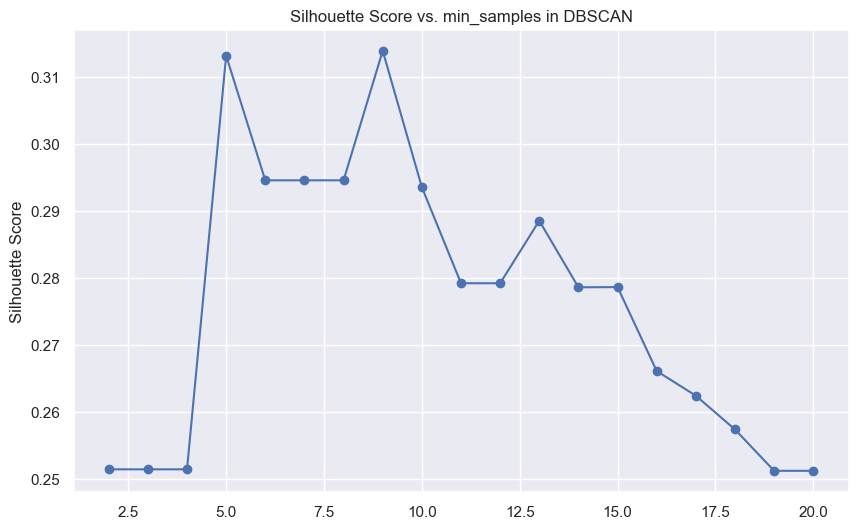

In [384]:
min_samples_values = np.arange(2, 21)  

silhouette_values = np.zeros(len(min_samples_values))

for idx, min_samples in enumerate(min_samples_values):
    try:
        preds = DBSCAN(eps=1.0, min_samples=min_samples).fit_predict(final_df)
        if len(np.unique(preds)) > 1:  # Skip if only one cluster and noise
            silhouette_values[idx] = silhouette_score(final_df, preds)
    except:
        pass

plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, silhouette_values, marker='o', linestyle='-', color='b')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. min_samples in DBSCAN')
plt.grid(True)
plt.show()

> for silhouette score there are 2 peaks one at 5 and one at around 9


## Eps = 0.9

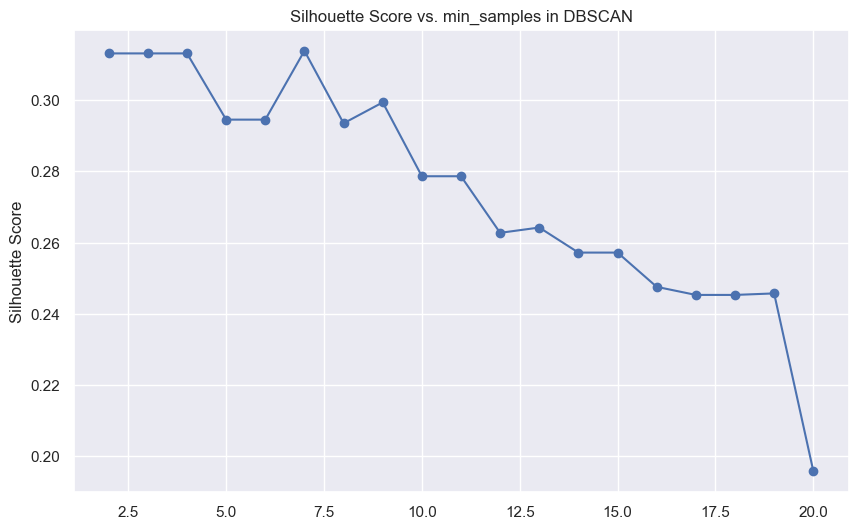

In [385]:
min_samples_values = np.arange(2, 21)  # Adjust the range as needed

silhouette_values = np.zeros(len(min_samples_values))

for idx, min_samples in enumerate(min_samples_values):
    try:
        preds = DBSCAN(eps=0.9, min_samples=min_samples).fit_predict(final_df)
        if len(np.unique(preds)) > 1:  # Skip if only one cluster and noise
            silhouette_values[idx] = silhouette_score(final_df, preds)
    except:
        pass

# Find index of maximum silhouette score
# max_silhouette_idx = np.argmax(silhouette_values)
# max_silhouette_min_samples = min_samples_values[max_silhouette_idx]
# max_silhouette_score = silhouette_values[max_silhouette_idx]

# Plotting the silhouette scores vs. min_samples values
plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, silhouette_values, marker='o', linestyle='-', color='b')
# plt.scatter(max_silhouette_min_samples, max_silhouette_score, color='red', label=f'Max Silhouette Score ({max_silhouette_score:.2f})')
# plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. min_samples in DBSCAN')
plt.grid(True)
# plt.legend()
plt.show()

> the silhoeutte score is quite different when eps = 0.9 however when comparing the values from the eps = 1.0 plot at around 5 and 9 the silhouette score for min_samples = 9 is slightly higher compared to min_samples = 5,  
><u> hence i will choose min_samples = 9 </u>

DBSCAN clusters Present [-1  0]


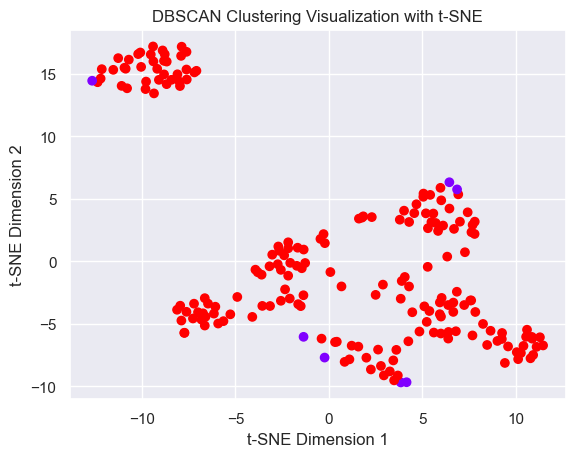

In [625]:
dbscan = DBSCAN(eps=0.9, min_samples=9).fit(final_df)
dbscan_fit = dbscan.fit(final_df)
dbscan_labels = dbscan_fit.labels_

tsne = TSNE(n_components=2, perplexity=30, random_state=10)
X_tsne = tsne.fit_transform(final_df)

print(f'DBSCAN clusters Present {np.unique(dbscan_labels)}')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='rainbow')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('DBSCAN Clustering Visualization with t-SNE')
plt.show()

>Look at the clustering its quite surprising as there is basically only 1 cluster, with the other just being the "noise" that DBSCAN labelled under a cluster, this is quite surprising as i expected DBSCAN to perform better than Kmeans, however it seems that DBSCAN is not suitable for this dataset, 

---

One thought i had was that maybe the parameter values i chosen was not suitable and not the best i could have chosen, hence i decided to try out other values for eps and min_samples to see if the number of clusters increases

<Axes: xlabel='Age', ylabel='Density'>

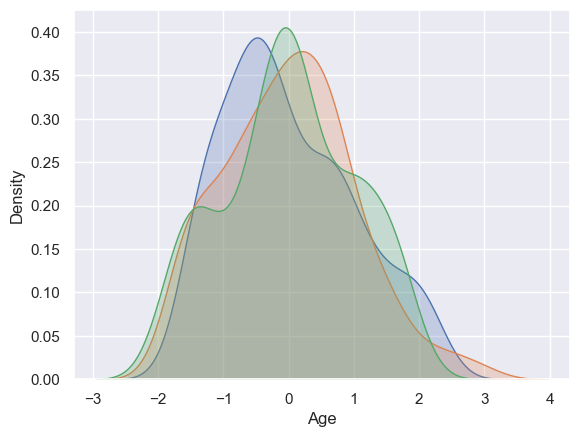

In [611]:
sns.kdeplot(final_df['Age'], cmap='Blues', shade=True, cbar=True)
sns.kdeplot(final_df['Income (k$)'], cmap='Blues', shade=True, cbar=True)
sns.kdeplot(final_df['How Much They Spend'], cmap='Blues', shade=True, cbar=True)

>Based on how dbscan works (Lutins, 2020), it mainly assumes that the datapoints have different densities and hence when the data is more gaussianly distributed, the densities might be more uniform across making dbscan less effective and harder to find clusters

### **Testing multiple eps and min sample values**

i still hold on to a sliver of hope, since KDE might not be the best way to estimate the density of the data, hence i decided to test out multiple values for eps and min_samples to see if i can get a better result

In [431]:
np.unique(dbscan_labels)
def testing(eps_range, min_samples_range):
    for e in eps_range:
        for m in min_samples_range:
            dbscan = DBSCAN(eps=e, min_samples=m).fit(final_df)
            dbscan_fit = dbscan.fit(final_df)
            dbscan_labels = dbscan_fit.labels_
            print(f'eps = {e}, min_samples = {m}')
            print(f'Number of clusters: {len(np.unique(dbscan_labels))}')
            print('-------------------------------------------') 


eps_start = 0.1
eps_end = 20
eps_step = 0.1
eps_range = np.arange(eps_start, eps_end + eps_step, eps_step)

min_samples_range = np.arange(2, 21)


testing(eps_range, min_samples_range)

eps = 0.1, min_samples = 2
Number of clusters: 5
-------------------------------------------
eps = 0.1, min_samples = 3
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 4
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 5
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 6
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 7
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 8
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 9
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 10
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 11
Number of clusters: 1
-------------------------------------------
eps = 0.1, min_samples = 12
Number of clusters: 1
------------------

> When eps = 0.1 and min samples = 5 i was hopefully, maybe DBSCANS is actually good, so i deicide to plot it out

DBSCAN clusters Present [-1  0  1  2  3]


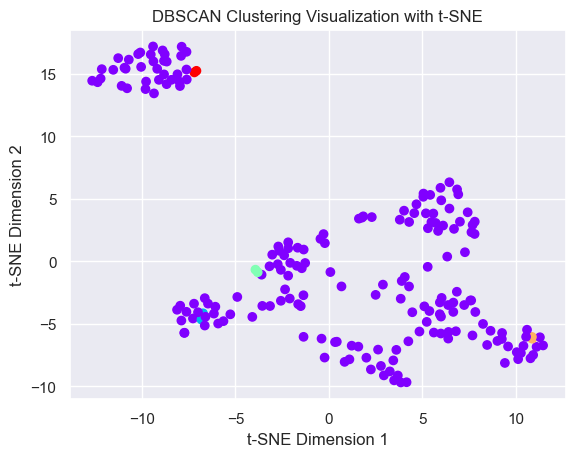

In [626]:
dbscan = DBSCAN(eps=0.1, min_samples=2).fit(final_df)
dbscan_fit = dbscan.fit(final_df)
dbscan_labels = dbscan_fit.labels_

tsne = TSNE(n_components=2, perplexity=30, random_state=10)
X_tsne = tsne.fit_transform(final_df)

print(f'DBSCAN clusters Present {np.unique(dbscan_labels)}')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='rainbow')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('DBSCAN Clustering Visualization with t-SNE')
plt.show()

> As we can see its still rubbish, it just split the 'Noise' cluster into smaller cluster.

>As we can see through a lot of eps values and min_samples values, the number of clusters is still 1, while the lower eps values do have 2 clusters its the same case and previously mention where 1 of the clusters are datapoints that are considered "noise", Hence i can confidently say that <u> DBSCAN is `NOT suitable` for this dataset</u>

---

## Agglomerative Hierarchical Clustering 

My last model i will try to test is agglomerative clustering, which is a hierarchical clustering method, the good thing about this is there isn't really a parameter i need to choose, so i can just run the clustering and see how it naturally clusters deciding on what to do as time goes on 

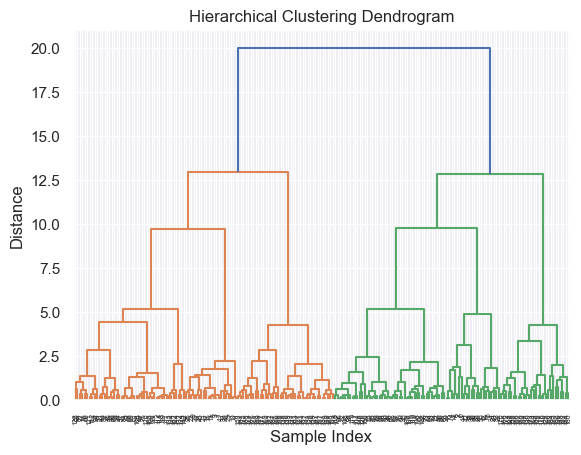

In [334]:
from scipy.cluster.hierarchy import dendrogram, linkage
# linkage set to ward first as its the most default value
# set n_clusters to None first to see the dendrogram
# affinity parameter can also be left default
agg_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0)

# Fit the model and obtain cluster labels
cluster_labels = agg_clustering.fit_predict(final_df)

# Create a dendrogram for visualization
linked = linkage(final_df, method='ward')  # Calculate linkage matrix
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()



>As we can see from the dendrogram, after distance 5 onwards it starts splitting into unncessary smaller clusters which might not help the cluster insights at all, hence i will choose distance = 7.5 as the distance to cut the dendrogram, as i believe that clusters after that distance onwards is unncessary

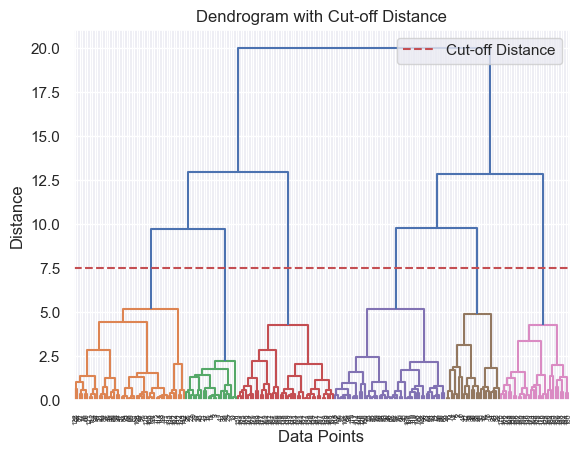

In [325]:
cut_distance = 7.5
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold= 7.5  # Set the cut-off distance
)

plt.axhline(y=cut_distance, color='r', linestyle='--', label='Cut-off Distance')

plt.legend(loc='upper right')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram with Cut-off Distance')
plt.show()

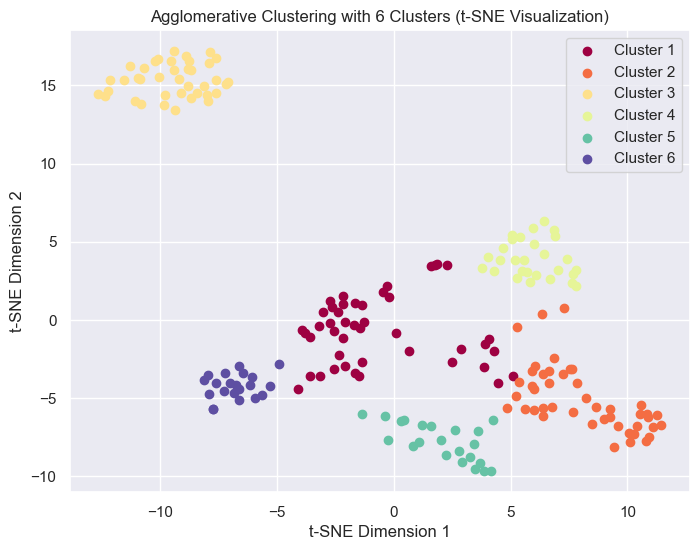

In [338]:
n_clusters = 6 
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

cluster_labels = agg_clustering.fit_predict(final_df)


tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(final_df)


plt.figure(figsize=(8, 6))

# Create a color map for the clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

# Iterate through each cluster label
for cluster_id, color in zip(range(n_clusters), colors):
    cluster_points = X_tsne[cluster_labels == cluster_id]  # Extract points in the cluster
    # num_points = len(cluster_points)
    # print(num_points)
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f'Cluster {cluster_id + 1}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title(f'Agglomerative Clustering with {n_clusters} Clusters (t-SNE Visualization)')
plt.legend()
plt.show()

>As we can see, after clustering the results are actually quite good, with each of the clusters well defined and distinct from each other.

i think the tuning of the parameters are not need as well since the parameters are in a good state already, with me not really needing to change anything, hence i will use this model as my final model

---

# final Model

With the model with the most distinct and well defined clusters being the agglomerative clustering model, i will use that as my final model tuning the parameters are not needed as it is already in a good state, hence i will use the model as it is

In [616]:
n_clusters = 6  
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Fit the model and obtain cluster labels
cluster_labels = agg_clustering.fit_predict(final_df)

# Apply t-SNE for visualization
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(final_df)


tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE Dimension 1', 't-SNE Dimension 2', 't-SNE Dimension 3'])
tsne_df['Cluster'] = cluster_labels

fig = px.scatter_3d(tsne_df, x='t-SNE Dimension 1', y='t-SNE Dimension 2', z='t-SNE Dimension 3',
                    color='Cluster', title='t-SNE 3D Visualization with Clusters')

# Show the plot
fig.show()



>Once again even in a 3d model the clusters are still quite distinct and well defined, with each cluster having its own distinct shape and size. Further emphasising my point that this is the best model for this dataset

## Getting information of each cluster

Once we cluster each data point into its respective cluster, i need to do the most important step that clustering is for, gaining insight into the customers of each cluster and how they are different from each other, i will choose to view the median of each group instead of the mean, as the median is more robust to outliers and hence will give me a better representation of the cluster

In [622]:
# lets still take a look at mean
# display(cluster_info)
n_clusters = 6  
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agg_labels = agg_clustering.fit_predict(final_df)
agg_clusters = df.copy(deep=True)
agg_clusters['agg_cluster'] = agg_labels

display(agg_clusters.groupby('agg_cluster').mean())


,Age,Income (k$),How Much They Spend
agg_cluster,,,
0,27.377778,57.511111,45.844444
1,56.400000,55.288889,48.355556
2,32.692308,86.538462,82.128205
3,43.892857,91.285714,16.678571
4,44.318182,25.772727,20.272727
5,24.809524,25.619048,80.238095


In [623]:
display(agg_clusters.groupby('agg_cluster').median())


,Age,Income (k$),How Much They Spend
agg_cluster,,,
0,26.0,60.0,50.0
1,54.0,54.0,48.0
2,32.0,79.0,83.0
3,43.5,87.0,16.0
4,45.5,24.5,16.0
5,23.0,24.0,77.0


so lets explain what each of the clusters tell me: 

- cluster 1: younger generation with high income, as well as relatively high spending for their age

- cluster 2: Older generation with average income, as well as average spending

- cluster 3: middle-aged with higher income and strong spending ability

- cluster 4: middle-middle aged customer with very high income however spending very frugally

- cluster 5: middle-middle aged customer with low income as well as low spending

- cluster 6: young customers with low income however extremely high spending 

The largest takeaways, income does not correlate with spending 
and never judge a customer spending based on their age

---

# For the Shopping mall

for the shopping mall, there are 2 types of customers to look out for

1. customers that are in cluster 6, younger customers with no concept of money love to spend implusively as evident by their low income but high spending, however the customer need not try their best to retain them, instead attracting more generations of such people, as after a while those same customer will grow up and stop spending on such scale, hence retaining them won't provide as much benefit as attracting more of such customers constantly

2. the most important customers to retain, belong to cluster 1, although there are 2 key clusters that are worthy notably cluster 1, and 3. I believe its more beneficial to retain cluster 1 as even at such younger age they have relatively higher income and currently have quite average spending, showing that just in a few years their income will far surpass others of the same age, allowing for higher spending power compared to customers in cluster 3. Hence to benefit the shopping mall the most, they should focus on retaining customers in cluster 1, as they will be the most profitable in the long run

----

# TLDR:
#### customer 1 is the most profittable in the long run and its the cluster of customer that the shopping mall should focus on retaining 

----

# References

`Silhouette Analysis`  
Selecting the number of clusters with silhouette analysis on KMeans clustering. (n.d.). Scikit-learn.  
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 


`Starting value of min_samples`  
Mullin, T. (2021, December 15). DBSCAN Parameter Estimation Using Python - Tara Mullin - Medium. Medium. https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

`Hopkins Statistic`  
Meerkat Statistics. (2023, April 25). Clustering - Hopkins Statistic - Definition and Code (Python) [Video]. YouTube. https://www.youtube.com/watch?v=E2VAV9eUh1o

`DBSCAN`  
Lutins, E. (2020, December 5). DBSCAN: What is it? When to Use it? How to use it - Evan Lutins - Medium. Medium. https://elutins.medium.com/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818

---

# Chicken Parmesan Recipe

## Ingredients
- 2 boneless, skinless chicken breasts
- 1 cup bread crumbs
- 1/2 cup grated Parmesan cheese
- 1/2 cup all-purpose flour
- 2 large eggs, beaten
- 1 cup marinara sauce
- 1 cup shredded mozzarella cheese
- 2 tablespoons olive oil
- Salt and pepper, to taste

## Instructions
1. Preheat the oven to 375°F (190°C).
2. In a shallow bowl, mix together the bread crumbs and grated Parmesan cheese.
3. Season the chicken breasts with salt and pepper.
4. Dredge each chicken breast in the flour, dip it into the beaten eggs, and then coat it with the bread crumb mixture.
5. In a large skillet, heat the olive oil over medium-high heat.
6. Add the breaded chicken breasts to the skillet and cook until golden brown on both sides, about 3-4 minutes per side.
7. Remove the chicken from the skillet and place it in a baking dish.
8. Pour the marinara sauce over the chicken breasts, covering them evenly.
9. Sprinkle the shredded mozzarella cheese over the top.
10. Bake in the preheated oven for 20-25 minutes, or until the chicken is cooked through and the cheese is melted and bubbly.
11. Remove from the oven and let it rest for a few minutes before serving.
12. Serve the Chicken Parmesan hot with pasta or a side of your choice.

Enjoy your delicious Chicken Parmesan!